In [1]:
# # QC tensorflow installation
# import tensorflow as tf
# import keras
# print(tf.__version__)
# print(keras.__version__)

# Command Space
# %

## Import Libraries

In [2]:
# Import required libraries
import numpy as np
import tensorflow as tf
# from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import os

## Load CIFAR-10 Dataset

We load the CIFAR-10 dataset, perform some preprocessing like normalization and one hot encoding of labels/targets.

In [3]:
import numpy as np
import os

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_train_test(data_dir):
    """
    Function to load CIFAR-10 training and test data.

    Args:
    data_dir (str): Path to the directory containing CIFAR-10 data files.

    Returns:
    X_train (ndarray): Training data features
    Y_train (ndarray): Training data labels
    X_test (ndarray): Test data features
    Y_test (ndarray): Test data labels
    """
    X_train = []
    Y_train = []

    for i in range(1, 6):  # Load training data from 5 batches
        batch_file = os.path.join(data_dir, 'data_batch_' + str(i))
        batch_data = unpickle(batch_file)
        X_train.append(batch_data[b'data'])
        Y_train += batch_data[b'labels']

    X_train = np.concatenate(X_train, axis=0)
    Y_train = np.array(Y_train)

    # Load test data from the test batch
    test_batch_file = os.path.join(data_dir, 'test_batch')
    test_batch_data = unpickle(test_batch_file)

    X_test = test_batch_data[b'data']
    Y_test = np.array(test_batch_data[b'labels'])

    # Reshaping and re-arranging color channels to represent RGB image required as input to CNN
    # Reshape to (50000, 3, 32, 32) and move the color channel axis to the last dimension
    X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return X_train, Y_train, X_test, Y_test


Create validation data from train set (20% split):

In [4]:
from sklearn.model_selection import train_test_split

# Directory containing CIFAR-10 data files
data_dir = 'dataset\cifar-10-python\cifar-10-batches-py'

# Load CIFAR-10 training and test data
X_train, Y_train, X_test, Y_test = load_cifar10_train_test(data_dir)

# Split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [5]:
# Ensuring we parsed the data correctly:
print('Train Set:')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('Validation Set:')
print('X_val shape: ', X_val.shape)
print('Y_val shape: ', Y_val.shape)
print('Test Set:')
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

Train Set:
X_train shape:  (40000, 32, 32, 3)
Y_train shape:  (40000,)
Validation Set:
X_val shape:  (10000, 32, 32, 3)
Y_val shape:  (10000,)
Test Set:
X_test shape:  (10000, 32, 32, 3)
Y_test shape:  (10000,)


### Setup ImageDataGenerator

In order to make the most of fewer training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

NOTE: ImageDataGenerator will NOT add new images to your data set in a sense that it will not make your epochs bigger. Instead, in each epoch it will provide slightly altered images (depending on your configuration). It will always generate new images, no matter how many epochs you have.

So in each epoch model will train on different images, but not too different. This should prevent overfitting and in some way simulates online learning.

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# Construct the training image generator for data augmentation
# datagen = ImageDataGenerator(
#         rotation_range=10, # rotation
#         width_shift_range=0.2, # horizontal shift
#         height_shift_range=0.2, # vertical shift
#         zoom_range=0.2, # zoom
#         horizontal_flip=True, # horizontal flip
#         # brightness_range=[0.2,1.0] # brightness
# )

# For purposes of creating a baseline, construct empty ImageDataGenerator
datagen = ImageDataGenerator()

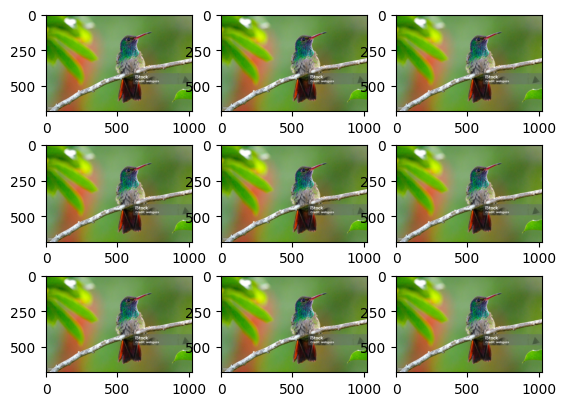

In [7]:
# Example of image augmentation on sample image:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot


img = load_img('bird.jpeg') # load image
data = img_to_array(img) # convert to numpy array
samples = expand_dims(data, 0) # expand dimension to one sample

# Prepare iterator
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i) # define subplot
    batch = it.next() # generate batch of images
    image = batch[0].astype('uint8') # convert to unsigned integers
    pyplot.imshow(image)

# show the figure
pyplot.show()
# Adapted code for displaying augmentation results: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

### Pre-processing dataset

In [8]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# One-hot encode the labels
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)
Y_val = to_categorical(Y_val, 10)

## Build and Train Model

The following cell has the supporting utility functions to plot accuracy curves, loss curves from training process and final evaluation of the classification model. I have provided inline comments explaining purpose of each function and code used. 

In [9]:
# Import required libraries
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    """
    Function to plot accuracy curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(title + " Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    save_plot(plt, title)
    plt.show()
    
def plot_multiple_accuracies(models, title):
    """
    Function to plot accuracy curves for both training and validation sets of multiple models at once.

    Args:
    models (Dictionary): Contains Keras History objects with training history assigned by keys that pertain to the hyperparameter value used
    title (str): Title of the plot
    """
    for key in models.keys():
        history = models[key]
        plt.plot(history.history['accuracy'], label='train_accuracy' + "_" + key)
        plt.plot(history.history['val_accuracy'], label='val_accuracy' + "_" + key)
    plt.title(title + " Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    save_plot(plt, title)
    plt.show()

def plot_loss(history, title):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title + " Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    save_plot(plt, title)
    plt.show()
    
def plot_multiple_losses(models, title):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    models (Dictionary): Contains Keras History objects with training history assigned by keys that pertain to the hyperparameter value used
    title (str): Title of the plot
    """
    for key in models.keys():
        history = models[key]
        plt.plot(history.history['loss'], label='train_loss' + "_" + key)
        plt.plot(history.history['val_loss'], label='val_loss' + "_" + key)
    plt.title(title + " Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    save_plot(plt, title)
    plt.show()

def evaluate_model(model, X_test, Y_test):
    """
    Function to evaluate the performance of a trained model on the test dataset.

    Args:
    model (Sequential): Trained Keras model
    X_test (ndarray): Test dataset features
    Y_test (ndarray): One-hot encoded labels for test dataset
    """
    _, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Accuracy: %.2f%%" % (accuracy * 100))
    return accuracy * 100
    
def save_plot(plt, name):
    """
    Function to save a plot. Call function before plt.show().

    Args:
    plt (matplotlib.pyplot object): Plot to save
    name (String): A String for the name of the output file. Cannot contain spaces
    """
    filepath = "Graphs/" + name
    # if os.path.isfile(filepath):
    #     filepath += "_second"
    #     print("Same filename. Please alter the params_string. You will not get another warning before losing figures!!")
    plt.savefig(filepath)


In [10]:
from tensorflow.keras.layers import Input, Add, Activation, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def resnet_block(inputs, filters, kernel_size, strides, skip_kernel_size=(1, 1), activation='relu', num_layers=2):
    """
    Function to create a single ResNet block.

    Args:
    inputs (tensor): Input tensor
    filters (int): Number of filters in the convolutional layers
    kernel_size (int or tuple): Size of the convolutional kernel
    strides (int or tuple): Strides of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    activation (str): Activation function to use
    num_layers (int): Number of convolutional layers per block

    Returns:
    tensor: Output tensor of the ResNet block
    """
    shortcut = inputs

    # Create initial convolutional layer and batch normalization without an activation layer afterwards
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    
    # Create (num_layers - 1) convolutional layers with activation layer beforehand
    # Final layer does not have an activation layer as desired
    if num_layers > 1:
        for i in range(num_layers - 1):
            x = Activation(activation)(x)
            x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
    

    # Shortcut connection
    if strides != 1 or inputs.shape[-1] != filters:
        # change (1,1) to variable (the kernel size in the ith skip connection)
        shortcut = Conv2D(filters, skip_kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

def build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(8, 8), optimizer='adam'):
    """
    Function to build a ResNet model using multiple Resnet style blocks.
    
    Args:
    init_filters (int): Number of filters in the first layer
    r_layers (list of ints): Network architecture as a list where the length of the list is the number of Residual Layers and the value of each element is the number of blocks in that layer
    conv_kernel_size (int or tuple): Size of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    conv_per_layer (int): Number of convolutional layers per residual block
    pool_size (int or tuple): Size of the pooling layer
    optimizer (String): Acceptable keras optimizers such as SGD or adam

    Returns:
    model (Model): Compiled ResNet model
    """
    inputs = Input(shape=(32, 32, 3))
    num_filters = init_filters
    num_blocks_list = res_layers  # ResNet Style architecture for CIFAR-10

    x = Conv2D(num_filters, conv_kernel_size, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add ResNet blocks
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 1
            if i > 0 and j == 0:  # Downsample at the beginning of each stage
                strides = 2
            x = resnet_block(x, num_filters, conv_kernel_size, strides, skip_kernel_size=skip_kernel_size, num_layers=conv_per_layer)

        num_filters *= 2  # Double the number of filters after each stage

    x = AveragePooling2D(pool_size=pool_size)(x) # pool size could be hyperparameter
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    # optimizer can be a parameter: vanilla sgd, sgd with fixed learning rate, or adam 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [11]:
# Build ResNet Model 1
resnet_model_1 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD')
resnet_model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

In [12]:
# # Build ResNet Model 2
# resnet_model_2 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD')
# resnet_model_2.summary()

In [13]:
# # Build ResNet Model 3
# resnet_model_3 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD')
# resnet_model_3.summary()

In [14]:
# # Build ResNet Model 4
# resnet_model_3 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD')
# resnet_model_3.summary()

TO DO:
1. keras callbacks: save checkpoint with best performance on validation data (rishie)
2. Add hyperparameter tuning as arguments (gio)
3. Save graphs under different names (gio)
4. ImageDataGenerator - read about this to add augmentation (rishie)
5. Regularization - Dropouts in random/hyperparameter
6. Loading custom data (rishie)

### Enabling Keras Callbacks

Callback to save the Keras model weights after every epoch that obtains the best validation accuracy thus far.

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Title of the Hypothesis Tested
title = "Baseline ResNet Model"

# These are used to distinguish the models from each other
param_1 = "Baseline"
# param_2 = ""
# param_3 = ""
# param_4 = ""

checkpoint_filepath_1 = 'ckpt/' + title + '/' + param_1
# checkpoint_filepath_2 = 'ckpt/' + title + '/' + param_2 
# checkpoint_filepath_3 = 'ckpt/' + title + '/' + param_3
# checkpoint_filepath_4 = 'ckpt/' + title + '/' + param_4

# Defining callback
model_checkpoint_callback_1 = ModelCheckpoint(
    filepath=checkpoint_filepath_1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# model_checkpoint_callback_2 = ModelCheckpoint(
#     filepath=checkpoint_filepath_2,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# model_checkpoint_callback_3 = ModelCheckpoint(
#     filepath=checkpoint_filepath_3,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# model_checkpoint_callback_4 = ModelCheckpoint(
#     filepath=checkpoint_filepath_4,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

In [16]:
# Augmenting on the fly with datagen.flow()
batch_size=64
epochs=30

histories = {}
keys = [param_1] #, param_2, param_3, param_4]
models = [resnet_model_1] #, resnet_model_2, resnet_model_3, resnet_model_4]
checkpoints = [model_checkpoint_callback_1] #, model_checkpoint_callback_2, model_checkpoint_callback_3, model_checkpoint_callback_4]
for i in range(len(models)):
# Directly use .flow() to load our dataset in batches for training
    histories[keys[i]] = models[i].fit(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                                    epochs = epochs, # set number of epochs
                                    steps_per_epoch = X_train.shape[0]//batch_size, # number of images composing one epoch
                                    validation_data = (X_val, Y_val), # data for validation
                                    callbacks=[checkpoints[i]], # model checkpoint
                                    verbose=1)

Epoch 1/30
622/625 [============================>.] - ETA: 0s - loss: 2.1401 - accuracy: 0.3960

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 19s 20ms/step - loss: 2.1367 - accuracy: 0.3965 - val_loss: 1.3482 - val_accuracy: 0.5256
Epoch 2/30
623/625 [============================>.] - ETA: 0s - loss: 1.2705 - accuracy: 0.5480

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 1.2708 - accuracy: 0.5479 - val_loss: 1.2385 - val_accuracy: 0.5628
Epoch 3/30
625/625 [==============================] - ETA: 0s - loss: 1.0850 - accuracy: 0.6152

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 1.0850 - accuracy: 0.6152 - val_loss: 1.1653 - val_accuracy: 0.5909
Epoch 4/30
622/625 [============================>.] - ETA: 0s - loss: 0.9445 - accuracy: 0.6662

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.9443 - accuracy: 0.6662 - val_loss: 1.1323 - val_accuracy: 0.6071
Epoch 5/30
624/625 [============================>.] - ETA: 0s - loss: 0.8334 - accuracy: 0.7071

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.8332 - accuracy: 0.7071 - val_loss: 1.1526 - val_accuracy: 0.6278
Epoch 6/30
623/625 [============================>.] - ETA: 0s - loss: 0.7470 - accuracy: 0.7378

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.7469 - accuracy: 0.7379 - val_loss: 0.9789 - val_accuracy: 0.6653
Epoch 7/30
623/625 [============================>.] - ETA: 0s - loss: 0.6643 - accuracy: 0.7666

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.6640 - accuracy: 0.7667 - val_loss: 0.9278 - val_accuracy: 0.6841
Epoch 8/30
625/625 [==============================] - ETA: 0s - loss: 0.5992 - accuracy: 0.7898

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.5992 - accuracy: 0.7898 - val_loss: 0.9004 - val_accuracy: 0.7017
Epoch 9/30
625/625 [==============================] - 9s 15ms/step - loss: 0.5281 - accuracy: 0.8167 - val_loss: 1.0395 - val_accuracy: 0.6563
Epoch 10/30
625/625 [==============================] - 9s 15ms/step - loss: 0.4763 - accuracy: 0.8355 - val_loss: 0.9907 - val_accuracy: 0.6844
Epoch 11/30
625/625 [==============================] - 9s 15ms/step - loss: 0.4122 - accuracy: 0.8605 - val_loss: 0.9175 - val_accuracy: 0.6975
Epoch 12/30
621/625 [============================>.] - ETA: 0s - loss: 0.3625 - accuracy: 0.8798

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.3630 - accuracy: 0.8795 - val_loss: 0.8663 - val_accuracy: 0.7158
Epoch 13/30
625/625 [==============================] - 10s 15ms/step - loss: 0.3183 - accuracy: 0.8943 - val_loss: 0.9679 - val_accuracy: 0.7007
Epoch 14/30
625/625 [==============================] - 9s 15ms/step - loss: 0.2715 - accuracy: 0.9154 - val_loss: 0.9400 - val_accuracy: 0.7101
Epoch 15/30
625/625 [==============================] - ETA: 0s - loss: 0.2361 - accuracy: 0.9296

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.2361 - accuracy: 0.9296 - val_loss: 0.9020 - val_accuracy: 0.7209
Epoch 16/30
625/625 [==============================] - 9s 15ms/step - loss: 0.1952 - accuracy: 0.9467 - val_loss: 0.9228 - val_accuracy: 0.7202
Epoch 17/30
625/625 [==============================] - 9s 15ms/step - loss: 0.1654 - accuracy: 0.9587 - val_loss: 0.9452 - val_accuracy: 0.7073
Epoch 18/30
624/625 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.9691

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.1384 - accuracy: 0.9690 - val_loss: 0.9353 - val_accuracy: 0.7275
Epoch 19/30
625/625 [==============================] - 9s 15ms/step - loss: 0.1155 - accuracy: 0.9775 - val_loss: 0.9644 - val_accuracy: 0.7174
Epoch 20/30
622/625 [============================>.] - ETA: 0s - loss: 0.0960 - accuracy: 0.9837

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.0960 - accuracy: 0.9838 - val_loss: 0.9553 - val_accuracy: 0.7293
Epoch 21/30
625/625 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9886

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.0808 - accuracy: 0.9886 - val_loss: 0.9233 - val_accuracy: 0.7357
Epoch 22/30
623/625 [============================>.] - ETA: 0s - loss: 0.0678 - accuracy: 0.9926

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.0679 - accuracy: 0.9926 - val_loss: 0.9199 - val_accuracy: 0.7386
Epoch 23/30
625/625 [==============================] - 10s 15ms/step - loss: 0.0569 - accuracy: 0.9951 - val_loss: 0.9339 - val_accuracy: 0.7378
Epoch 24/30
624/625 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9966

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.0490 - accuracy: 0.9966 - val_loss: 0.9200 - val_accuracy: 0.7421
Epoch 25/30
623/625 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9974

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.0426 - accuracy: 0.9974 - val_loss: 0.9579 - val_accuracy: 0.7428
Epoch 26/30
624/625 [============================>.] - ETA: 0s - loss: 0.0359 - accuracy: 0.9987

INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


INFO:tensorflow:Assets written to: ckpt/Baseline ResNet Model\Baseline\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.0359 - accuracy: 0.9987 - val_loss: 0.9355 - val_accuracy: 0.7512
Epoch 27/30
625/625 [==============================] - 9s 15ms/step - loss: 0.0329 - accuracy: 0.9987 - val_loss: 0.9659 - val_accuracy: 0.7434
Epoch 28/30
625/625 [==============================] - 9s 15ms/step - loss: 0.0303 - accuracy: 0.9990 - val_loss: 1.0104 - val_accuracy: 0.7352
Epoch 29/30
625/625 [==============================] - 9s 15ms/step - loss: 0.0256 - accuracy: 0.9994 - val_loss: 0.9502 - val_accuracy: 0.7497
Epoch 30/30
625/625 [==============================] - 9s 15ms/step - loss: 0.0234 - accuracy: 0.9996 - val_loss: 1.0011 - val_accuracy: 0.7470


In [17]:
# resnet_history = resnet_model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_val, Y_val))


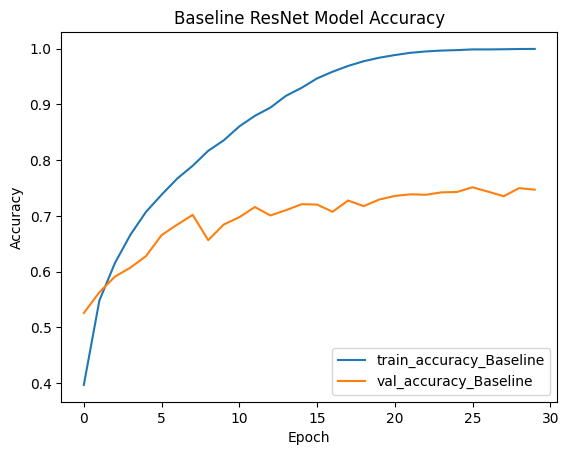

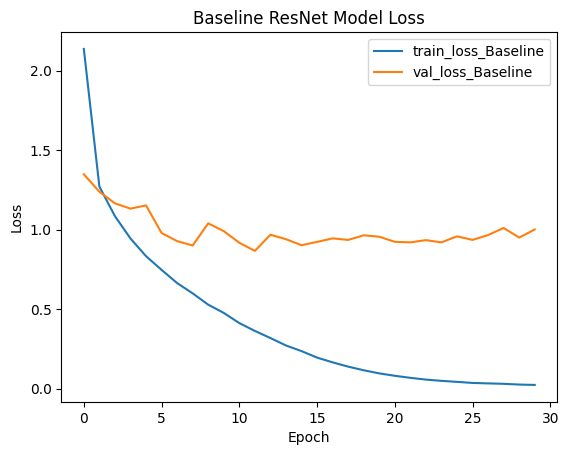

In [18]:
# Plot accuracy and loss
# accuracy_title = title + ' Accuracy'
# loss_title = title + ' Loss'
# plot_accuracy(resnet_history, accuracy_title)
# plot_loss(resnet_history, loss_title)

# Plot all models' accuracies and losses on the same graph:
plot_multiple_accuracies(histories, title)
plot_multiple_losses(histories, title)

In [19]:
# Load the model with the maximum validation accuracy from checkpoint on disk
test_model_1 = tf.keras.models.load_model(checkpoint_filepath_1)
# test_model_2 = tf.keras.models.load_model(checkpoint_filepath_2)
# test_model_3 = tf.keras.models.load_model(checkpoint_filepath_3)
# test_model_4 = tf.keras.models.load_model(checkpoint_filepath_4)

In [23]:
# Evaluate test set using best version of each model and save outputs to a file
print(title + ':')
accuracy_list = []
for i in range(len(models)):
    accuracy_list.append(evaluate_model(models[i], X_test, Y_test))

with open("Test_Accuracy.txt", 'w') as file:
    file_title = title + ':'
    file.write(file_title)
    for i in range(len(accuracy_list)):
        acc_string = str(keys[i]) + str(accuracy_list[i])
        file.write(acc_string)
    file.write('\n')

Baseline ResNet Model:
Test Accuracy: 73.52%


In [27]:
from playsound import playsound
playsound("GOT TO GO.mp3")
playsound("GOT TO GO.mp3")
playsound("GOT TO GO.mp3")